<img src="https://www.saperessere.com/wp-content/uploads/2013/08/logo-sapienza-new.jpg" width="300"/>

# Directions and information from this notebook

The aim of this notebook is to create models regarding the synthetic dataset of BLENDER created. 

Inside of this notebook is written the whole code to generate the models to predict the number of devices given a position (of the station), day and hour in March 2022.

# Install libraries

In [ ]:
!pip install catboost
!pip install tune-sklearn

     |████████████████████████████████| 76.6 MB 1.4 MB/s 
     |████████████████████████████████| 40 kB 2.4 MB/s 
     |████████████████████████████████| 53.2 MB 144 kB/s 
     |████████████████████████████████| 8.8 MB 30.4 MB/s 
     |████████████████████████████████| 144 kB 52.8 MB/s 
     |████████████████████████████████| 4.1 MB 41.0 MB/s 
     |████████████████████████████████| 125 kB 41.9 MB/s 
     |████████████████████████████████| 461 kB 50.1 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.



# Import libraries

In [ ]:
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from numpy import cos, sin, arcsin, sqrt
from math import radians, ceil
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import datetime
from datetime import date, timedelta
from IPython.display import clear_output
import seaborn as sns
import hashlib
import sqlite3

import pickle
from tqdm import tqdm
import os
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from hyperopt import fmin, space_eval, tpe, hp

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

from scipy import stats
from scipy.stats import skew

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import RobustScaler

import plotly.graph_objects as go

sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


# Define functions

In the following cell I left the functions' definition used. Each one of them have their own explanation.

In [ ]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    :dt: Datetime

    :return adjusted_dom: Week of the month in number
    """

    # Force the first day
    first_day = dt.replace(day=1)

    # Get day of month
    dom = dt.day
    
    # Adjust the date to the corresponding week
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

# Define parameters

Within this parameter's definition, the aim is to be able to run the code easily, only by changing the location where the whole data is (or will be) stored.

In [ ]:
# Define paths
root_path = '/content/gdrive/MyDrive/Students_honour_programme/project_with_professor_Francesca_Cuomo'
%cd $root_path

output_path = root_path + '/output'
models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc"]

/content/gdrive/MyDrive/Students_honour_programme/project_with_professor_Francesca_Cuomo


# Load data

The data **full_data_generated.csv** contains the synthetic data generated after running the Nobook called *02_Synthetic data generation and EDA.ipynb*.

In [ ]:
# Load the whole data to avoid re-running
data_merged = pd.read_csv("data/full_data_generated.csv", sep=";", encoding='utf-8', dtype = {"station_id" : "str","fingerprint_id" : "str"})
data_merged['received_at'] = pd.to_datetime(data_merged['received_at'], format='%Y-%m-%d %H:%M:%S.%f')

# Define cases and features

In the following cell, it is stated the feature engineering step, where the explanatory variables for the stations were created.

In [ ]:
# Get the day of the month
data_merged['day_of_moth'] = data_merged.received_at.dt.day
# Get the week of the month
data_merged['week_month'] = data_merged.received_at.apply(week_of_month) - 1
# Get the weekday
data_merged['day_week'] = data_merged.received_at.dt.weekday
# data_merged['date'] = data_merged.received_at.dt.date
# Get the hour of the day
data_merged['hour'] = data_merged.received_at.dt.hour
# Get the minute of the hour
data_merged['minute'] = data_merged.received_at.dt.minute
# Get the date only
data_merged['date'] = data_merged.received_at.dt.date
# Get the name for the day of the week
data_merged['day_week_name'] = data_merged.received_at.dt.day_name().astype(str).str.slice(start=0, stop=3)


In [ ]:
data_merged.columns

Index(['station_id', 'fingerprint_id', 'latitude', 'longitude', 'received_at', 'nd', 'type', 'address', 'place_name', 'device_id', 'day_of_moth', 'week_month', 'day_week', 'hour', 'minute', 'date', 'day_week_name'], dtype='object')

In [ ]:
# Get a simple desribe of the data to check if the features make sense or have something particular to correct
# grouped_data = data_merged.groupby(['station_id','day_of_moth','hour','minute']).count().reset_index()[['station_id','day_of_moth','hour','minute','nd']]
grouped_data = data_merged.groupby(['station_id','place_name','latitude','longitude','type','day_of_moth','date','hour','week_month','day_week','day_week_name']).count().reset_index()[['station_id','place_name','latitude','longitude','type','day_of_moth','date','hour','week_month','day_week','day_week_name','nd']]
grouped_data.describe()

,latitude,longitude,day_of_moth,hour,week_month,day_week,nd
count,85135.000000,85135.000000,85135.000000,85135.000000,85135.000000,85135.000000,85135.000000
mean,41.892187,12.493430,15.919093,11.284736,1.893675,2.663370,19.726446
std,0.017283,0.030293,9.058830,6.662468,1.328224,1.802593,20.021743
min,41.830541,12.435273,1.000000,0.000000,0.000000,0.000000,1.000000
25%,41.885202,12.476317,8.000000,6.000000,1.000000,1.000000,7.000000
50%,41.894986,12.485309,16.000000,11.000000,2.000000,3.000000,13.000000
75%,41.903325,12.503505,24.000000,17.000000,3.000000,4.000000,24.000000
max,41.950697,12.586104,31.000000,23.000000,4.000000,6.000000,311.000000


# Predict the number of devices

In the following cell, it is presented the data splitting to get train, validation and test data when fitting the proposed models.

In [ ]:
# Define features and label
X = grouped_data.drop(['station_id','place_name','date','day_week_name','nd'], axis=1)
X = pd.get_dummies(X).reset_index(drop=True)
y = grouped_data['nd']


# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 15% (for each) of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = random_state)

# X = x_train
# y = y_train

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

# Define parameters for fine tuning
num_folds = 5

kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

X Train shape: (59594, 18)
Y Train shape: (59594,)
X Validation shape: (12770, 18)
Y Validation shape: (12770,)
X Test shape: (12771, 18)
Y Test shape: (12771,)


# Using XG-Boost regressor

In case you want to re-fit the model, it is necessary to set the `load_model` parameter as `False`. On the contrary, if you only want to load the already trained model, then `load_model` can remain as `True`.

X Train shape: (59594, 18)
Y Train shape: (59594,)
X Validation shape: (12770, 18)
Y Validation shape: (12770,)
X Test shape: (12771, 18)
Y Test shape: (12771,)
100%|██████████| 10/10 [06:55<00:00, 41.55s/it, best loss: 6.021596069839421]
[19:15:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: 
{'colsample_bytree': 0.7709994859968945, 'max_depth': 7, 'min_child_weight': 10.0, 'n_estimators': 300, 'reg_alpha': 0.0}
Evaluating results of the regression:
RMSE Score for train, validation, test: 5.06592, 5.53315, 5.77231
RMSE Score for train, validation, test: 0.93628, 0.92012, 0.91866
Feature importance:
Ejecución: 438.2788116931915 seconds


(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 <a list of 7 Text major ticklabel objects>)

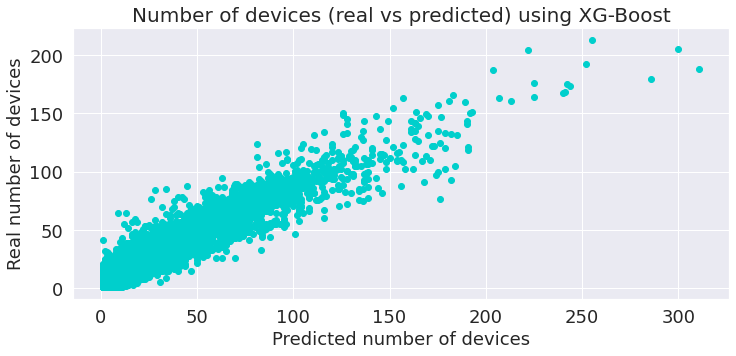

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_XGboost.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( XGBRegressor(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,10,1))
        , 'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
        , 'n_estimators': hp.choice('n_estimators', [300])
        , 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1)
        , 'reg_alpha' : hp.quniform('reg_alpha', 0,1,1)
        # , 'reg_lambda' : hp.uniform('reg_lambda', 0,1)
        # , 'gamma': hp.uniform ('gamma', 0,0.5)
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  xgb_grid = make_pipeline( XGBRegressor(random_state = random_state, **best_params))

  # Train Model
  xgb_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)
  with open(models_path + '/best_params_XGboost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = xgb_grid.predict(x_train)
ypred_train = np.where(ypred_train<1,1,ypred_train)
# Predict values of regression with validation
ypred_val = xgb_grid.predict(x_val)
ypred_val = np.where(ypred_val<1,1,ypred_val)
# Predict values of regression with test
ypred_test = xgb_grid.predict(x_test)
ypred_test = np.where(ypred_test<1,1,ypred_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)))
# Feature importance calculation
# imps = permutation_importance(xgb_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

f, axs = plt.subplots(1,1,figsize=(40,5))
plt.subplot(1, 3, 1)
plt.scatter(y_train, ypred_train,alpha = 1, color=colors[0])
plt.xlabel('Predicted number of devices', fontsize=18)
plt.ylabel('Real number of devices', fontsize=18)
plt.title(r'Number of devices (real vs predicted) using XG-Boost', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [ ]:
# Define metrics in a dataframe
metrics_xgb = {'metric_name':  ['RMSE', 'RMSE', 'RMSE', 'R-Squared', 'R-Squared', 'R-Squared'],
           'set_used': ['Train', 'Validation', 'Test','Train', 'Validation', 'Test'],
           'metric_value': [rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test),r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)]
        }

metrics_xgb = pd.DataFrame (metrics_xgb, columns = ['metric_name', 'set_used','metric_value'])

# Plot metrics
fig = go.Figure(data=[
    go.Bar(name='Train', x=metrics_xgb[metrics_xgb['set_used']=="Train"]['metric_name'], y=metrics_xgb[metrics_xgb['set_used']=="Train"]['metric_value'], marker_color='#007f88'),
    go.Bar(name='Validation', x=metrics_xgb[metrics_xgb['set_used']=="Validation"]['metric_name'], y=metrics_xgb[metrics_xgb['set_used']=="Validation"]['metric_value'], marker_color='#00cccd'),
    go.Bar(name='Test', x=metrics_xgb[metrics_xgb['set_used']=="Test"]['metric_name'], y=metrics_xgb[metrics_xgb['set_used']=="Test"]['metric_value'], marker_color='#69e0da')
])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Metric",
    yaxis_title="Metric value",
    legend_title="Dataset",)

fig.show()

# Using Catboost regressor

In case you want to re-fit the model, it is necessary to set the `load_model` parameter as `False`. On the contrary, if you only want to load the already trained model, then `load_model` can remain as `True`.

X Train shape: (59594, 18)
Y Train shape: (59594,)
X Validation shape: (12770, 18)
Y Validation shape: (12770,)
X Test shape: (12771, 18)
Y Test shape: (12771,)
100%|██████████| 10/10 [05:45<00:00, 34.56s/it, best loss: 7.40411717795089]
0:	learn: 19.8424174	total: 56.8ms	remaining: 56.7s
1:	learn: 19.6075299	total: 65.1ms	remaining: 32.5s
2:	learn: 19.4151024	total: 73.5ms	remaining: 24.4s
3:	learn: 19.2344890	total: 82ms	remaining: 20.4s
4:	learn: 19.0670010	total: 90.4ms	remaining: 18s
5:	learn: 18.9028200	total: 98.4ms	remaining: 16.3s
6:	learn: 18.7477334	total: 107ms	remaining: 15.1s
7:	learn: 18.5576146	total: 115ms	remaining: 14.3s
8:	learn: 18.3605423	total: 123ms	remaining: 13.6s
9:	learn: 18.2319801	total: 131ms	remaining: 13s
10:	learn: 18.0533573	total: 139ms	remaining: 12.5s
11:	learn: 17.9214597	total: 147ms	remaining: 12.1s
12:	learn: 17.7929293	total: 155ms	remaining: 11.8s
13:	learn: 17.6729362	total: 163ms	remaining: 11.5s
14:	learn: 17.5311777	total: 171ms	remaining

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 10 Text major ticklabel objects>)

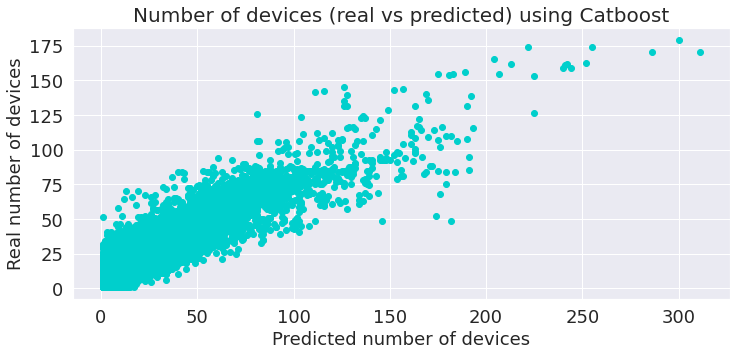

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/CatBoost_model.pkl','rb')
  cat_model_f = pickle.load(infile)
  infile = open(models_path + '/params_CatBoost_model.pkl','rb')
  best_params = pickle.load(infile)

else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( CatBoostRegressor(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  # parameters = {'iterations': hp.choice('iterations', [1000,6000])
  parameters = {'iterations': hp.choice('iterations', [250,100,500,1000, 2000])
        , 'eval_metric': hp.choice('eval_metric', ['RMSE'])
        , 'early_stopping_rounds': hp.choice('early_stopping_rounds', [200])
        , 'learning_rate': hp.choice('learning_rate', [0.05, 0.005, 0.0005])
        , 'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 9])
        # , 'depth': hp.choice('depth', [4, 6, 10])
    }
# 
  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  cat_f = make_pipeline( CatBoostRegressor(random_state = random_state, **best_params))  

  # Train model  
  cat_model_f = cat_f.fit(x_train,y_train)

  #Save model
  with open(models_path + '/CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(cat_model_f, pickfile)
  with open(models_path + '/params_CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = cat_model_f.predict(x_train)
ypred_train = np.where(ypred_train<1,1,ypred_train)
# Predict values of regression with validation
ypred_val = cat_model_f.predict(x_val)
ypred_val = np.where(ypred_val<1,1,ypred_val)
# Predict values of regression with test
ypred_test = cat_model_f.predict(x_test)
ypred_test = np.where(ypred_test<1,1,ypred_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(cat_model_f, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

f, axs = plt.subplots(1,1,figsize=(40,5))
plt.subplot(1, 3, 1)
plt.scatter(y_train, ypred_train,alpha = 1, color=colors[0])
plt.xlabel('Predicted number of devices', fontsize=18)
plt.ylabel('Real number of devices', fontsize=18)
plt.title(r'Number of devices (real vs predicted) using Catboost', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [ ]:
# Define metrics in a dataframe
metrics_catboost = {'metric_name':  ['RMSE', 'RMSE', 'RMSE', 'R-Squared', 'R-Squared', 'R-Squared'],
           'set_used': ['Train', 'Validation', 'Test','Train', 'Validation', 'Test'],
           'metric_value': [rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test),r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)]
        }

metrics_catboost = pd.DataFrame (metrics_catboost, columns = ['metric_name', 'set_used','metric_value'])

# Plot metrics
fig = go.Figure(data=[
    go.Bar(name='Train', x=metrics_catboost[metrics_catboost['set_used']=="Train"]['metric_name'], y=metrics_catboost[metrics_catboost['set_used']=="Train"]['metric_value'], marker_color='#007f88'),
    go.Bar(name='Validation', x=metrics_catboost[metrics_catboost['set_used']=="Validation"]['metric_name'], y=metrics_catboost[metrics_catboost['set_used']=="Validation"]['metric_value'], marker_color='#00cccd'),
    go.Bar(name='Test', x=metrics_catboost[metrics_catboost['set_used']=="Test"]['metric_name'], y=metrics_catboost[metrics_catboost['set_used']=="Test"]['metric_value'], marker_color='#69e0da')
])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Metric",
    yaxis_title="Metric value",
    legend_title="Dataset",)

fig.show()

# Using Random Forest

In case you want to re-fit the model, it is necessary to set the `load_model` parameter as `False`. On the contrary, if you only want to load the already trained model, then `load_model` can remain as `True`.

X Train shape: (59594, 18)
Y Train shape: (59594,)
X Validation shape: (12770, 18)
Y Validation shape: (12770,)
X Test shape: (12771, 18)
Y Test shape: (12771,)
100%|██████████| 10/10 [08:30<00:00, 51.08s/it, best loss: 8.569144111211846]
Best parameters found: 
{'bootstrap': True, 'max_depth': 13, 'max_features': 15, 'min_samples_split': 4, 'n_estimators': 300}
Evaluating results of the regression:
RMSE Score for train, validation, test: 7.77429, 7.96652, 8.85059
RMSE Score for train, validation, test: 0.84993, 0.83441, 0.80876
Feature importance:
Ejecución: 549.8810448646545 seconds


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 <a list of 11 Text major ticklabel objects>)

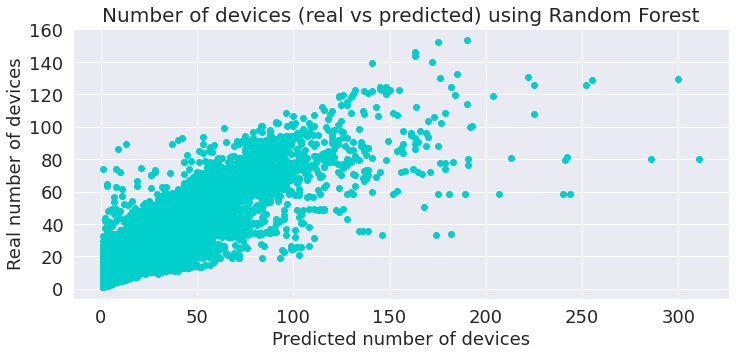

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_RandomForest.pkl','rb')
  best_params = pickle.load(infile)  
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( RandomForestRegressor(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'n_estimators': hp.choice('n_estimators', [300])
        , 'max_depth': hp.choice('max_depth', range(3,20,2))
        , 'min_samples_split' : hp.choice('min_samples_split', range(1,10,1)) 
        , 'max_features' : hp.choice('max_features', range(1,17,1)) 
        , 'bootstrap' : hp.choice('bootstrap', [True, False]) 
        
        # , 'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,20,1))
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  rf_grid = make_pipeline( RandomForestRegressor(random_state = random_state, **best_params))

  # Fit the model
  rf_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)
  with open(models_path + '/best_params_RandomForest.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = rf_grid.predict(x_train)
ypred_train = np.where(ypred_train<1,1,ypred_train)
# Predict values of regression with validation
ypred_val = rf_grid.predict(x_val)
ypred_val = np.where(ypred_val<1,1,ypred_val)
# Predict values of regression with test
ypred_test = rf_grid.predict(x_test)
ypred_test = np.where(ypred_test<1,1,ypred_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(rf_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

f, axs = plt.subplots(1,1,figsize=(40,5))
plt.subplot(1, 3, 1)
plt.scatter(y_train, ypred_train,alpha = 1, color=colors[0])
plt.xlabel('Predicted number of devices', fontsize=18)
plt.ylabel('Real number of devices', fontsize=18)
plt.title(r'Number of devices (real vs predicted) using Random Forest', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [ ]:
# Define metrics in a dataframe
metrics_rf = {'metric_name':  ['RMSE', 'RMSE', 'RMSE', 'R-Squared', 'R-Squared', 'R-Squared'],
           'set_used': ['Train', 'Validation', 'Test','Train', 'Validation', 'Test'],
           'metric_value': [rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test),r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)]
        }

metrics_rf = pd.DataFrame (metrics_rf, columns = ['metric_name', 'set_used','metric_value'])

# Plot metrics
fig = go.Figure(data=[
    go.Bar(name='Train', x=metrics_rf[metrics_rf['set_used']=="Train"]['metric_name'], y=metrics_rf[metrics_rf['set_used']=="Train"]['metric_value'], marker_color='#007f88'),
    go.Bar(name='Validation', x=metrics_rf[metrics_rf['set_used']=="Validation"]['metric_name'], y=metrics_rf[metrics_rf['set_used']=="Validation"]['metric_value'], marker_color='#00cccd'),
    go.Bar(name='Test', x=metrics_rf[metrics_rf['set_used']=="Test"]['metric_name'], y=metrics_rf[metrics_rf['set_used']=="Test"]['metric_value'], marker_color='#69e0da')
])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=700,
    height=500, xaxis_title="Metric",
    yaxis_title="Metric value",
    legend_title="Dataset",
    font=dict(size=20))

fig.show()

## Visualize comparison of models regarding R-Squared

In [ ]:
# Define overall index in a dataframe
compare = pd.concat([metrics_xgb[metrics_xgb['metric_name'] == "R-Squared"]
                     ,metrics_catboost[metrics_catboost['metric_name'] == "R-Squared"]
                     ,metrics_rf[metrics_rf['metric_name'] == "R-Squared"]
                     ], axis=0, ignore_index=True)

compare['method'] = ["XG-Boost"] * 3 + ["Catboost"] * 3 + ["Random Forest"] * 3

# Plot overall index across models
fig = go.Figure(data=[
    go.Bar(name='Train', x=compare[compare['set_used']=="Train"]['method'], y=compare[compare['set_used']=="Train"]['metric_value'], marker_color='#007f88'),
    go.Bar(name='Validation', x=compare[compare['set_used']=="Validation"]['method'], y=compare[compare['set_used']=="Validation"]['metric_value'], marker_color='#00cccd'),
    go.Bar(name='Test', x=compare[compare['set_used']=="Test"]['method'], y=compare[compare['set_used']=="Test"]['metric_value'], marker_color='#69e0da')
], layout_yaxis_range=[0,1])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=900,
    height=500, xaxis_title="Model employed",
    yaxis_title="R-Squared value",
    legend_title="Dataset",
    font=dict(size=20))


## Visualize comparison of models regarding Root Mean Squared Error (RMSE)

In [ ]:
# Define overall index in a dataframe
compare = pd.concat([metrics_xgb[metrics_xgb['metric_name'] == "RMSE"]
                     ,metrics_catboost[metrics_catboost['metric_name'] == "RMSE"]
                     ,metrics_rf[metrics_rf['metric_name'] == "RMSE"]
                     ], axis=0, ignore_index=True)

compare['method'] = ["XG-Boost"] * 3 + ["Catboost"] * 3 + ["Random Forest"] * 3

# Plot overall index across models
fig = go.Figure(data=[
    go.Bar(name='Train', x=compare[compare['set_used']=="Train"]['method'], y=compare[compare['set_used']=="Train"]['metric_value'], marker_color='#007f88'),
    go.Bar(name='Validation', x=compare[compare['set_used']=="Validation"]['method'], y=compare[compare['set_used']=="Validation"]['metric_value'], marker_color='#00cccd'),
    go.Bar(name='Test', x=compare[compare['set_used']=="Test"]['method'], y=compare[compare['set_used']=="Test"]['metric_value'], marker_color='#69e0da')
], layout_yaxis_range=[0,10])
# Change the bar mode
fig.update_layout(barmode='group', autosize=False,
    width=900,
    height=500, xaxis_title="Model employed",
    yaxis_title="RMSE value",
    legend_title="Dataset",
    font=dict(size=20))


# Visualize the prediction along the time for all the stations



In [ ]:
# Get prediction in the whole dataset
grouped_data['number_devices_pred'] = np.round(xgb_grid.predict(X),0).astype(int)
grouped_data['number_devices_pred'] = np.where(grouped_data['number_devices_pred']<1,1,grouped_data['number_devices_pred'])

# Get the date and hour to set the slider in the map
grouped_data['date_hour'] = pd.to_datetime(grouped_data.date.astype(str) + " " + grouped_data.hour.astype(str).str.pad(2,fillchar='0'), format='%Y-%m-%d %H')
grouped_data["date_hour"] = grouped_data["date_hour"].dt.strftime("%a %d-%b-%y hour: %H:00")

In [ ]:
# Define token from mapbox
px.set_mapbox_access_token(open(root_path + "/data/mapbox_token.txt").read())

# Define map
fig = px.scatter_mapbox(grouped_data,
                        lat=grouped_data.latitude,
                        lon=grouped_data.longitude,
                        hover_name="place_name",
                        animation_frame="date_hour",
                        width=1300,
                        height=750,
                        zoom=11.3,
                        color="type", size="number_devices_pred", size_max = grouped_data["number_devices_pred"].quantile(.92),
                        color_discrete_sequence = px.colors.qualitative.Light24,
                        opacity = 0.7
                        )

fig.update_layout(legend_font_size=20, hoverlabel=dict(font=dict(family='sans-serif', size=20)), sliders = [dict(font={'size': 20})])


fig.show()

Output hidden; open in https://colab.research.google.com to view.